# Notebook for doing parameter estimation of LDS with Poisson observations using `ssm` from Linderman lab

In [1]:
from scipy.linalg import block_diag
import autograd.numpy as np
import matplotlib.pyplot as plt
import ssm

from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from real_spike.utils import get_spike_events, kalman_filter, bin_spikes, butter_filter
from scipy.ndimage import gaussian_filter1d
from matplotlib import colormaps
from ssm.plots import plot_dynamics_2d

%matplotlib inline

# Get data

In [2]:
mat = loadmat("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt2.mat")
mat = mat['data']

print(mat.dtype.names)

('totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success')


In [3]:
data_struct = mat[0, 0]  # MATLAB structs are 2D arrays even if 1x1
data = {field: data_struct[field] for field in mat.dtype.names}

In [4]:
data.keys()

dict_keys(['totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success'])

# Get single-reach trials

In [5]:
control_idxs = np.where(data["pattern_id"] == 0)[0]
control_idxs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  21,  27,  33,  39,  45,  51,  57,  63,  69,  75,
        81,  87,  93,  99, 105, 111, 117, 123, 129, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 440, 441,
       442, 443, 444, 445, 446, 447, 448, 449])

In [6]:
stim_idxs = np.where(data["pattern_id"][:150] > 2)[0]

# control_idxs = np.intersect1d(control_idxs, stim_idxs)
# con
control_idxs = np.sort(np.concatenate((control_idxs, stim_idxs)))

In [7]:
# get no laser trials
control_idxs = np.intersect1d(control_idxs, np.where(data["single"] == 1)[1])

In [8]:
#control_idxs = np.sort(np.concatenate((a, b)))
control_idxs

array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  12,  14,  15,
        17,  19,  20,  21,  23,  24,  30,  33,  36,  39,  40,  43,  44,
        45,  46,  49,  50,  51,  53,  54,  60,  61,  62,  63,  67,  69,
        70,  71,  74,  77,  81,  82,  88,  89,  91, 105, 107, 116, 117,
       137, 139, 145, 148])

In [9]:
np.unique(data["pattern_id"][control_idxs])

array([ 0, 14, 17, 20], dtype=uint8)

## Get relevant time information

In [10]:
cue_times = data["cue_rec_time"][:, :150]
cue_times[:, control_idxs]

array([[  14310.86566601,   31635.98602851,   66118.75767016,
          83391.57934485,  100671.38676484,  117878.88228075,
         135202.39780987,  152469.08335693,  169748.98517889,
         187076.46559048,  221580.66647786,  256113.84876805,
         343834.9853677 ,  378401.3027471 ,  412964.5048617 ,
         430223.16624186,  447413.10299254,  481960.06796941,
         499231.75682054,  603021.71245162,  654737.65694326,
         706335.69338242,  758001.60483338,  775155.48003398,
         826860.47389786,  844093.36354196,  861313.50892099,
         878540.9232512 ,  930339.75266686,  947557.06598697,
         964758.89738507,  999343.5287454 , 1016540.9232512 ,
        1120486.35891627, 1137781.83706221, 1155099.87727745,
        1172344.18955914, 1241575.09676201, 1276101.01010101,
        1293329.17964694, 1310604.83338053, 1362412.63098272,
        1414270.55602757, 1483298.49900878, 1500421.5047673 ,
        1604049.56103087, 1621268.29038044, 1655724.06306051,
        

In [11]:
lift_times = data["lift_ms"][:, :150]
lift_times[:, control_idxs]

array([[310., 280., 330., 320., 300., 250., 270.,  90., 260., 260., 230.,
        230., 310., 290., 200., 280., 220., 270., 270., 300., 230., 290.,
        290., 310., 270., 320., 280., 290., 250., 270., 250., 280., 270.,
        290., 270., 270., 270., 260., 300., 320., 310., 310., 280., 280.,
        340., 270., 300., 310., 300., 300., 290., 200., 290., 340., 250.,
        220.]])

In [12]:
mouth_times = data["mouth_ms"][:, :150]
mouth_times[:, control_idxs]

array([[540., 540., 560., 570., 520., 540., 600., 460., 510., 490., 500.,
        530., 510., 520., 510., 630., 510., 480., 520., 570., 490., 670.,
        590., 570., 510., 640., 520., 560., 480., 520., 530., 490., 590.,
        520., 550., 570., 620., 520., 510., 550., 580., 650., 510., 520.,
        570., 480., 570., 550., 570., 530., 500., 560., 530., 570., 590.,
        480.]])

## Get the AP.bin file

In [13]:
from real_spike.utils import get_sample_data, get_meta
import tifffile

In [14]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.meta")

In [15]:
meta_data = get_meta(meta_path)

In [16]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 166298223)

## Get conversion params

In [17]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

In [18]:
vmax

0.6

In [19]:
imax

512.0

In [20]:
gain

500.0

# Get trials

In [97]:
all_data = list()

# HYPERPARAMETERS TO TOGGLE
bin_size = 10

p_colors = list()
c = {0: "indigo", 14: "teal", 17: "magenta", 20: "orange"}

for i in tqdm(control_idxs):
    trial_no = i
    p_colors.append(c[data["pattern_id"][i][0]])
    # get time points in ap space
    lift_time = int((cue_times[:, trial_no] + lift_times[:, trial_no] - 50) / 1_000 * 30_000)
    
    # get end of behavior = mouth (260ms) + 300ms 
    end_behavior = int((cue_times[:, trial_no] + mouth_times[:, trial_no] + 260) / 1_000 * 30_000)
    #print(lift_time, end_behavior)

    trial = ap_data[:150, lift_time:end_behavior]

    conv_data = 1e6 * trial / vmax / imax / gain

    filt_data = butter_filter(conv_data, 1_000, 30_000)

    c_start = int(cue_times[:, trial_no] / 1_000 * 30_000)
    m_start = c_start - (30 * 2000)
    trial_median = ap_data[:150, m_start:c_start]

    trial_median = 1e6 * trial_median / vmax / imax / gain
    trial_median = butter_filter(trial_median, 1_000, 30_000)
    
    median = np.median(trial_median, axis=1)

    spike_ixs, counts = get_spike_events(filt_data, median)
    
    a = np.zeros((filt_data.shape[0], filt_data.shape[1]))

    for i, sc in enumerate(spike_ixs):
        a[i, sc] = 1

    b = bin_size * 30 # 30ms per bin
    binned_spikes = bin_spikes(a, b)

    sigma = 5

    #smoothed = gaussian_filter1d(binned_spikes, sigma=sigma, axis=1)

    all_data.append(binned_spikes)

  0%|                                          | 0/56 [00:00<?, ?it/s]/tmp/ipykernel_19090/3491807208.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lift_time = int((cue_times[:, trial_no] + lift_times[:, trial_no] - 50) / 1_000 * 30_000)
/tmp/ipykernel_19090/3491807208.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_behavior = int((cue_times[:, trial_no] + mouth_times[:, trial_no] + 260) / 1_000 * 30_000)
/tmp/ipykernel_19090/3491807208.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing th

# Shorten trial to just around dynamics we care about

In [98]:
# model_data = list()

# lift_start = int(50 / bin_size)
# after_lift = int(300 / bin_size) + lift_start


# for d in all_data:
#     # smooth spikes
#     #d = gaussian_filter1d(d, sigma=5, axis=1)
#     model_data.append(np.asarray(d[:, lift_start:after_lift].T, dtype=int))

# Visual trials

In [99]:
# fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# # Flatten axes array for easy iteration
# axes = axes.flatten()

# for i, array in enumerate(model_data[:10]):
#     ax = axes[i]
#     d = ax.imshow(array, aspect="auto", interpolation="none", cmap="inferno")
#     ax.set_xlabel("Times (ms)")
#     ax.set_ylabel("Channel")

#     fig.colorbar(d, ax=ax)


#     ax.set_title(f"Trial {control_idxs[i]}") 


# # Adjust layout
# plt.tight_layout()

# #fig.colorbar()

# #plt.savefig("/home/clewis/repos/realSpike/data/rb50_20250127/binned_spikes_heatmap.png")

# plt.show()

# Create model

In [100]:
# smooth the data 
model_data = list()

lift_start = int(50 / bin_size)
after_lift = int(300 / bin_size) + lift_start


for d in all_data:
    # smooth spikes
    d = gaussian_filter1d(d, sigma=5, axis=1)
    model_data.append(np.asarray(d[:, lift_start:after_lift].T, dtype=int))

In [101]:
state_dim = 3
obs_dim = model_data[0].shape[1] 

(state_dim, obs_dim)

(3, 150)

In [102]:
plds = ssm.LDS(obs_dim, state_dim, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))

# set bias vector to 0
#plds.emissions.ds = 0 * np.ones(obs_dim)

# Fit the model

In [103]:
elbos, q = plds.fit(model_data, method="laplace_em", num_iters=25)

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

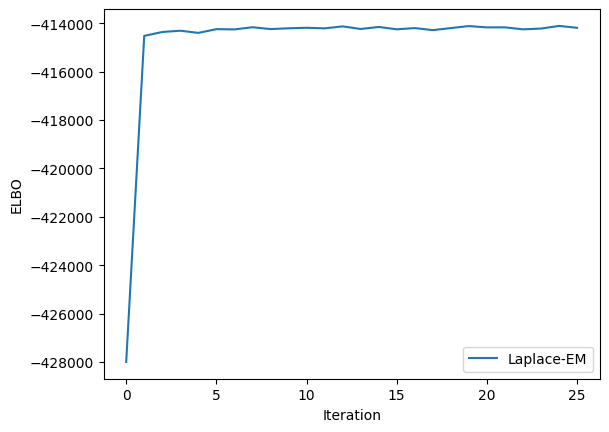

In [104]:
# Plot the ELBOs
plt.plot(elbos, label="Laplace-EM")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()

plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/plds_elbo_{bin_size}ms.png")

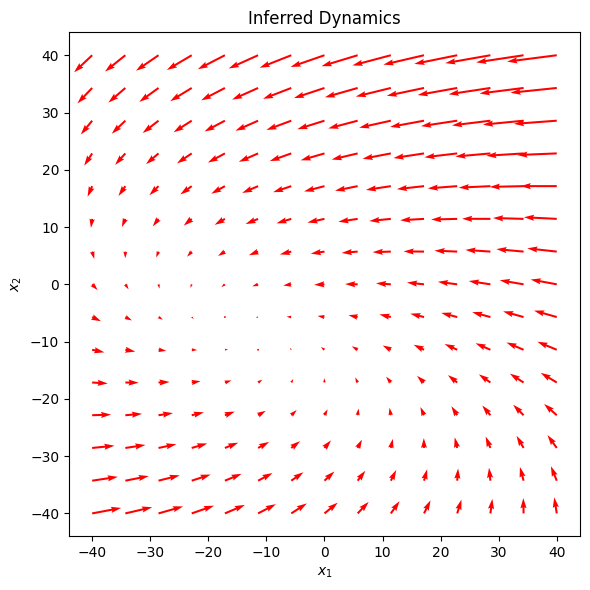

In [105]:
# Extract dynamics matrix from the true model
# A_true = true_lds.dynamics.A
# b_true = true_lds.dynamics.b

A_est = plds.dynamics.A
b_est = plds.dynamics.b

f, ax = plt.subplots(1, 1, figsize=(6, 6))
# plot_dynamics_2d(A_true, b_true, npts=10, axis=ax[0], color=colors[0])
# ax[0].set_xlabel("$x_1$")
# ax[0].set_ylabel("$x_2$")
# ax[0].set_title("True Dynamics")

plot_dynamics_2d(A_est[:2, :2] , b_est[:2], npts=15, axis=ax, color="red")
#plt.plot(states_plds[:,0], states_plds[:,1], '-k', lw=3)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_title("Inferred Dynamics")

plt.tight_layout()

plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/plds_dynamics_{bin_size}ms.png")
plt.show()

##  estimated expected values of the latent (hidden) continuous variables given the observed data and the current model parameters

The posterior mean of the continuous states is the expected value:

This mean can be interpreted as the best guess (under mean squared error) of the hidden latent state trajectory explaining the observed data, taking into account both the system dynamics and the Poisson likelihood of the observations.

In [106]:
# Get the posterior mean of the continuous states
state_means = q.mean_continuous_states

# Plot all the posterior means together 2D

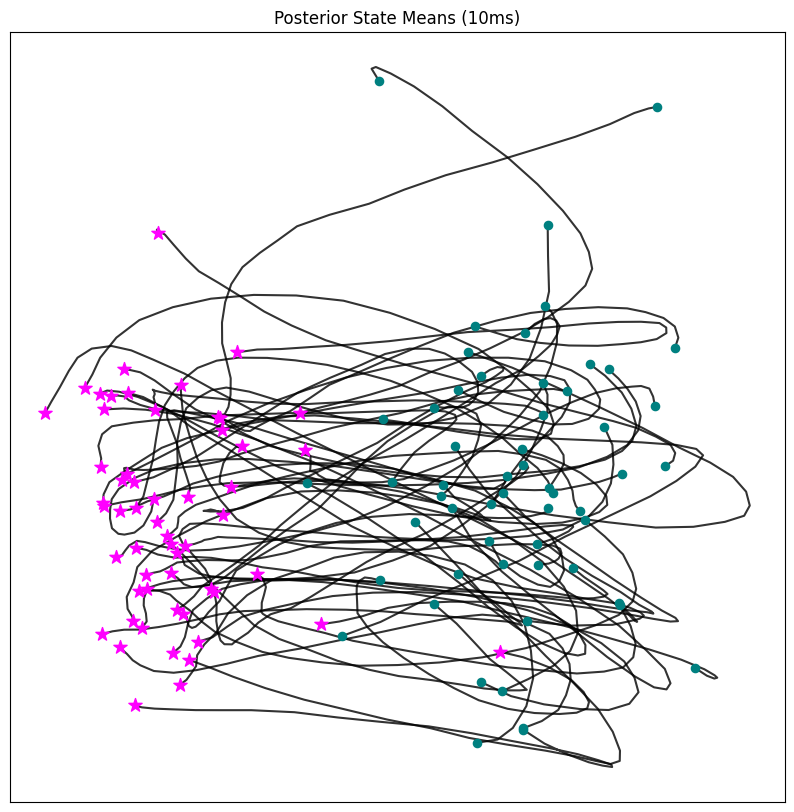

In [107]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, p in enumerate(state_means):

    lift = int(data["lift_ms"][0, control_idxs[i]] / bin_size) 
    # grab duration
    grab = int(data["grab_ms"][0,control_idxs[i]] / bin_size)
    # mouth duration 
    mouth = int(data["mouth_ms"][0,control_idxs[i]] / bin_size)

    lift_start = int(50 / bin_size)
    grab_start = lift_start + (grab - lift)
   # mouth_start = lift_start + (mouth-lift)

    ax.plot(p[lift_start:, 0], p[lift_start:, 1], c="black", zorder=0, alpha=0.8)

    ax.scatter(p[lift_start, 0], p[lift_start, 1], s=35, c="teal", zorder=1, alpha=1)
    #ax.scatter(p[grab - lift + lift_start, 0], p[grab-lift +lift_start, 1], p[grab-lift +lift_start, 2], s=10, c="red")
    ax.scatter(p[-1, 0], p[-1, 1], s=100, marker='*', c="magenta", zorder=1, alpha=1)

ax.set_title(f"Posterior State Means ({bin_size}ms)")



ax.set_xticks([])
ax.set_yticks([])


plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/plds_posterior_means_{bin_size}ms_2d.png")
plt.show()

# Plot all the posterior means together 3D

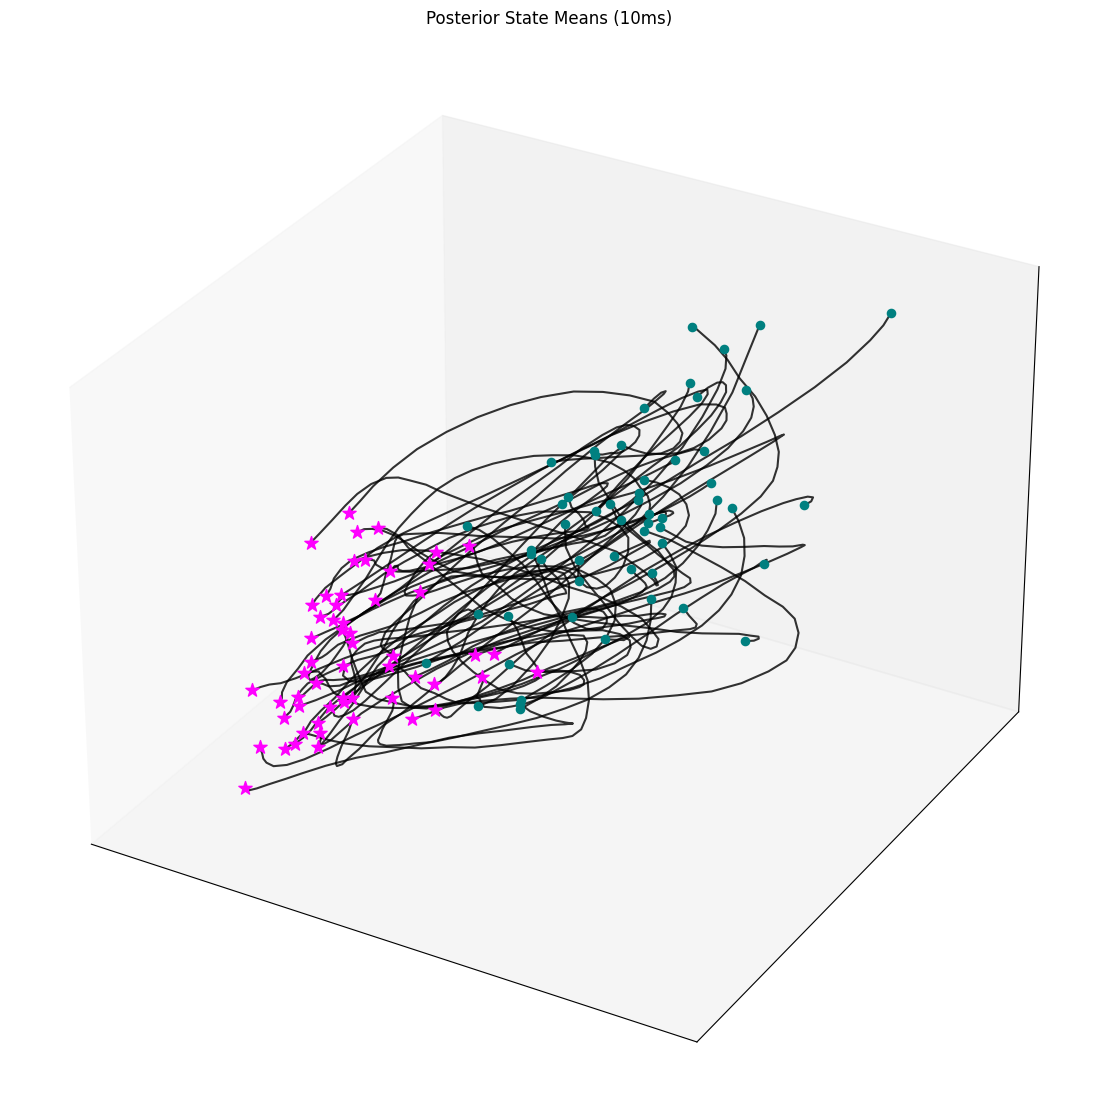

In [108]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')

for i, p in enumerate(state_means):

    lift = int(data["lift_ms"][0, control_idxs[i]] / bin_size) 
    # grab duration
    grab = int(data["grab_ms"][0,control_idxs[i]] / bin_size)
    # mouth duration 
    mouth = int(data["mouth_ms"][0,control_idxs[i]] / bin_size)

    lift_start = int(50 / bin_size)
    grab_start = lift_start + (grab - lift)
   # mouth_start = lift_start + (mouth-lift)

    ax.plot(p[lift_start:, 0], p[lift_start:, 1], p[lift_start:, 2], c="black", zorder=0, alpha=0.8)

    ax.scatter(p[lift_start, 0], p[lift_start, 1], p[lift_start, 2], s=35, c="teal", zorder=1, alpha=1)
    #ax.scatter(p[grab - lift + lift_start, 0], p[grab-lift +lift_start, 1], p[grab-lift +lift_start, 2], s=10, c="red")
    ax.scatter(p[-1, 0], p[-1, 1], p[-1, 2], s=100, marker='*', c="magenta", zorder=1, alpha=1)

ax.set_title(f"Posterior State Means ({bin_size}ms)")


ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/plds_posterior_means_{bin_size}ms_3d.png")
plt.show()